In [129]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs
from desi_lowz_funcs import calc_normalized_dist
from desi_lowz_funcs import find_objects_nearby
from construct_dwarf_galaxy_catalogs import process_sga_matches
from desi_lowz_funcs import sdss_rgb


Selecting the examples

In [130]:
elg_shreds = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")
bgsf_shreds = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
bgsb_shreds = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")



In [131]:
shred_all = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v4.fits")
clean_all = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_clean_catalog_v4.fits")


In [132]:
# temp = shred_all[ (shred_all["MAG_R"] < 22.05) & (shred_all["MAG_R"] > 21.95) & (shred_all["FRACFLUX_R"] < 7.175) & (shred_all["FRACFLUX_R"] >  7.165) & (shred_all["SAMPLE"] == "ELG") & (shred_all["Z"] < 0.1) ]
# # print(len(temp))

# print_radecs(temp, ra = "RA", dec="DEC", num = 200)

total_cat = vstack([shred_all, clean_all])

In [133]:
# Define magnitude bins and corresponding marker sizes
mag_bins = [0, 18, 19, 20, 21, 22, 23, 100]  # magnitude bins
# marker_sizes = [400, 300, 200, 150, 100, 50, 25]  # corresponding marker sizes
marker_sizes = [500, 400, 300, 250, 200, 125, 75]  # corresponding marker sizes

print(len(marker_sizes))
def mag_to_size(rmag):
    """
    Convert r-band magnitude(s) to marker size(s) based on defined bins.
    
    Parameters:
        rmag : float or array-like
            Magnitude or array of magnitudes.
    
    Returns:
        size : float or np.array
            Corresponding marker size(s).
    """
    rmag = np.atleast_1d(rmag)  # ensure array
    indices = np.digitize(rmag, mag_bins) - 1  # find bin index
    sizes = np.array([marker_sizes[i] for i in indices])
    return sizes if sizes.size > 1 else sizes[0]


7


In [178]:
import glob
from astropy.io import fits
from astropy.wcs import WCS
from desi_lowz_funcs import make_subplots

def get_image_summary(ax,data_table, near_cat=None, cutout_size = 40, img_folder = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/", fsize = 12,label=0):
    '''
    This function returns the rgb color image overlayed with circles showing the DR9 sources. The source that is targeted by DESI fiber is colored differently for reference
    '''
    ra = data_table["RA"][0]
    dec = data_table["DEC"][0]
    tgid = data_table["TARGETID"][0]
    zred = data_table["Z"][0]
    rmag = data_table["MAG_R"][0]
    # mstar = data_table["LOGM_SAGA_FIDU"][0]
    save_path = data_table["FILE_PATH"][0]

    print(ra,dec)
    
    img_path_k = img_folder + "image_tgid_%d*.fits"%(tgid) 
    img_path_k = glob.glob(img_path_k)[0]
        
    img_data = fits.open(img_path_k)
    data_arr = img_data[0].data
    wcs = WCS(fits.getheader( img_path_k ))

    org_size = np.shape(data_arr)[1]

    ## plot the rgb image of this galaxy with some given size
    rgb_stuff = sdss_rgb([data_arr[0],data_arr[1],data_arr[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)


    ## load the source catalog in this object:
    try:
        source_cat_f = Table.read(save_path + "/source_cat_f_more.fits")
    except:
        source_cat_f = Table.read(save_path + "/source_cat_f.fits")
        
    
    
    #get the pixel locations of these sources 
    sources_f_xpix,sources_f_ypix,_ = wcs.all_world2pix(source_cat_f['ra'].data, source_cat_f['dec'].data, 0,1)

    #identify the source that has DESI fiber!
    all_star_seps = SkyCoord(ra, dec, unit='deg').separation(SkyCoord( source_cat_f["ra"].data , source_cat_f["dec"].data, unit='deg')).arcsec

    source_f_rmags = source_cat_f["mag_r"].data

    
    fiber_xpix = sources_f_xpix[np.argmin(all_star_seps)]
    fiber_ypix = sources_f_ypix[np.argmin(all_star_seps)]
    fiber_rmag = source_f_rmags[np.argmin(all_star_seps)]
              
    ## plot the image
    ax.imshow(rgb_stuff,origin="lower")

    #for plotting the sources, let us make different sized markers to indicate that is the magnitude of the source
    # <18, 18-19, 19-20, 20-21, 21-22, 22-23
    sizes = mag_to_size(source_f_rmags)
    size_source = mag_to_size(fiber_rmag)

    ax.scatter(sources_f_xpix, sources_f_ypix,facecolor='none',edgecolor='white',lw=1,s=sizes,linestyle='dotted')

    bar_frac = 15/cutout_size

    cutout_size = int(cutout_size/0.262)
    #this makes the it an integer!
    start = (org_size - cutout_size) // 2
    end = start + cutout_size    
    ax.set_xlim([start,end])
    ax.set_ylim([start,end])
    
    ax.set_xticks([])
    ax.set_yticks([])

    ##indicate some text detialing some properties?
    ax.text(0.125,0.95,f"({ra:.3f}, {dec:.3f}), z = {zred:.3f}",size = 13,transform=ax.transAxes, 
            verticalalignment='top',color = "white")
    
    # ax.text(0.05,0.8,r"$r_{\rm mag,DR9} = %.1f$, FRACFLUX_R = %.2f, "%(rmag, data_table["FRACFLUX_R"][0]),size = fsize,transform=ax.transAxes, verticalalignment='top',color = "red",bbox=dict(facecolor='black', alpha=0.75, pad=5) )
    ax.text(0.025,0.95,r"%d"%(label),size = 20,transform=ax.transAxes, verticalalignment='top',color = "white",bbox=dict(facecolor='black', alpha=0.8, pad=2) )
    
    ax.set_title(r"mag$_{r} = %.1f$, FRACFLUX_R = %.2f "%(rmag, data_table["FRACFLUX_R"][0]),size = fsize, color = "k",fontsize = 13)

    # Define bar length in fraction of axes width (e.g., 0.3 = 30% of width)
    x_start_frac = 0.07  # 7% from left
    y_start_frac = 0.07  # 7% from bottom
    
    # Draw the scale bar in axes coordinates
    ax.plot([x_start_frac, x_start_frac + bar_frac],
            [y_start_frac, y_start_frac],
            color='white', lw=1, transform=ax.transAxes)


    if near_cat is not None:
        if len(near_cat) > 1:
            #get the pixel locations of these sources 
            near_xpix,near_ypix,_ = wcs.all_world2pix(near_cat['TARGET_RA'].data, near_cat['TARGET_DEC'].data, 0,1)
    
            #we need to figure out what is the closest source and color that one!
            for i in range(len(near_cat)):
                all_seps_i = SkyCoord(near_cat['TARGET_RA'].data[i], near_cat['TARGET_DEC'].data[i], unit='deg').separation(SkyCoord( source_cat_f["ra"].data , source_cat_f["dec"].data, unit='deg')).arcsec
                idx = np.argmin(all_seps_i)
                size_near_i = sizes[idx]
                ax.scatter(near_xpix[i], near_ypix[i],facecolor='none',edgecolor='red',lw=1,s=size_near_i,linestyle='-')
                ax.scatter(near_xpix[i], near_ypix[i],facecolor='none',edgecolor='white',lw=1.5,s=size_near_i,linestyle='dotted')

    #plotting at the end on top of everything!
    # ax.scatter( sources_f_xpix, sources_f_ypix,facecolor="none",edgecolor = "white",lw =0.75,s=400,ls = "dotted" )
    ax.scatter( fiber_xpix, fiber_ypix,facecolor="none",edgecolor = "r",lw =2,s=size_source )


    return source_cat_f


In [149]:
lowz_shreds = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")

lowz_shred_egs = [2706108581937152, 2706150235570177, 2706236185247745, 2706316862685184]
# 2706212579704832

lowz_0 = lowz_shreds[lowz_shreds["TARGETID"] == lowz_shred_egs[0]]
lowz_1 = lowz_shreds[lowz_shreds["TARGETID"] == lowz_shred_egs[1]]
lowz_2 = lowz_shreds[lowz_shreds["TARGETID"] == lowz_shred_egs[2]]
lowz_3 = lowz_shreds[lowz_shreds["TARGETID"] == lowz_shred_egs[3]]



In [150]:
other_tgids = [39627752084603180, 39627600171107076,39627869990684670, 39628242323243938 ]

data_0 = shred_all[shred_all["TARGETID"] == other_tgids[0]]
data_1 = shred_all[shred_all["TARGETID"] == other_tgids[1]]
data_2 = shred_all[shred_all["TARGETID"] == other_tgids[2]]
data_3 = shred_all[shred_all["TARGETID"] == other_tgids[3]]


In [151]:
iron_cat = Table.read("/pscratch/sd/v/virajvm/trash/zpix_iron_small_v2.fits")

def search_around_radec(tgid, dwarf_cat, catalog,c_ra="RA",c_dec="DEC",search_rad_arc = 60,use_spectype=True):
    # ra_col = "TARGET_RA"
    # dec_col ="TARGET_DEC" 
    ra_col = "RA"
    dec_col ="DEC" 
    center_cat = dwarf_cat[dwarf_cat["TARGETID"] == tgid]
    
    ra,dec,zred = center_cat[ra_col][0], center_cat[dec_col][0], center_cat["Z"][0]
    
    near_cat = find_objects_nearby(catalog, ra,dec,deg_rad = search_rad_arc/3600, ra=c_ra,dec=c_dec)

    #only include galaxies that are at the same redshift!!
    near_cat = near_cat[np.abs(near_cat["Z"] - center_cat["Z"]) < 0.002]

    if use_spectype:
        print("Filtering by SPECTYPE")
        near_cat = near_cat[near_cat["SPECTYPE"] == "GALAXY"]

    print(f"Found {len(near_cat)} nearby sources")
    
    return center_cat, near_cat
    
    

In [152]:
_,near_data_0 = search_around_radec(other_tgids[0], shred_all, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 60,use_spectype=True)
_,near_data_1 = search_around_radec(other_tgids[1], shred_all, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 60,use_spectype=True)
_,near_data_2 = search_around_radec(other_tgids[2], shred_all, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 60,use_spectype=True)
_,near_data_3 = search_around_radec(other_tgids[3], shred_all, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 60,use_spectype=True)


Filtering by SPECTYPE
Found 5 nearby sources
Filtering by SPECTYPE
Found 1 nearby sources
Filtering by SPECTYPE
Found 3 nearby sources
Filtering by SPECTYPE
Found 1 nearby sources


In [157]:
_,near_lowz_0 = search_around_radec(lowz_shred_egs[0], shred_all, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 60,use_spectype=True)
_,near_lowz_1 = search_around_radec(lowz_shred_egs[1], shred_all, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 60,use_spectype=True)
_,near_lowz_2 = search_around_radec(lowz_shred_egs[2], shred_all, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 60,use_spectype=True)
_,near_lowz_3 = search_around_radec(lowz_shred_egs[3], shred_all, iron_cat,c_ra="TARGET_RA",c_dec="TARGET_DEC",search_rad_arc = 60,use_spectype=True)


Filtering by SPECTYPE
Found 2 nearby sources
Filtering by SPECTYPE
Found 2 nearby sources
Filtering by SPECTYPE
Found 3 nearby sources
Filtering by SPECTYPE
Found 2 nearby sources


214.26206310270314 -1.503325260416453
133.14261025691368 -7.645232088409582
42.61540995579803 3.5671737244520383
37.85279871518745 19.162227628554728
168.6348456996021 -3.3467887408591914
214.50253345946322 1.9374389475791407
131.57068765846995 -1.475959047207423
349.91995154044287 5.217129675441559


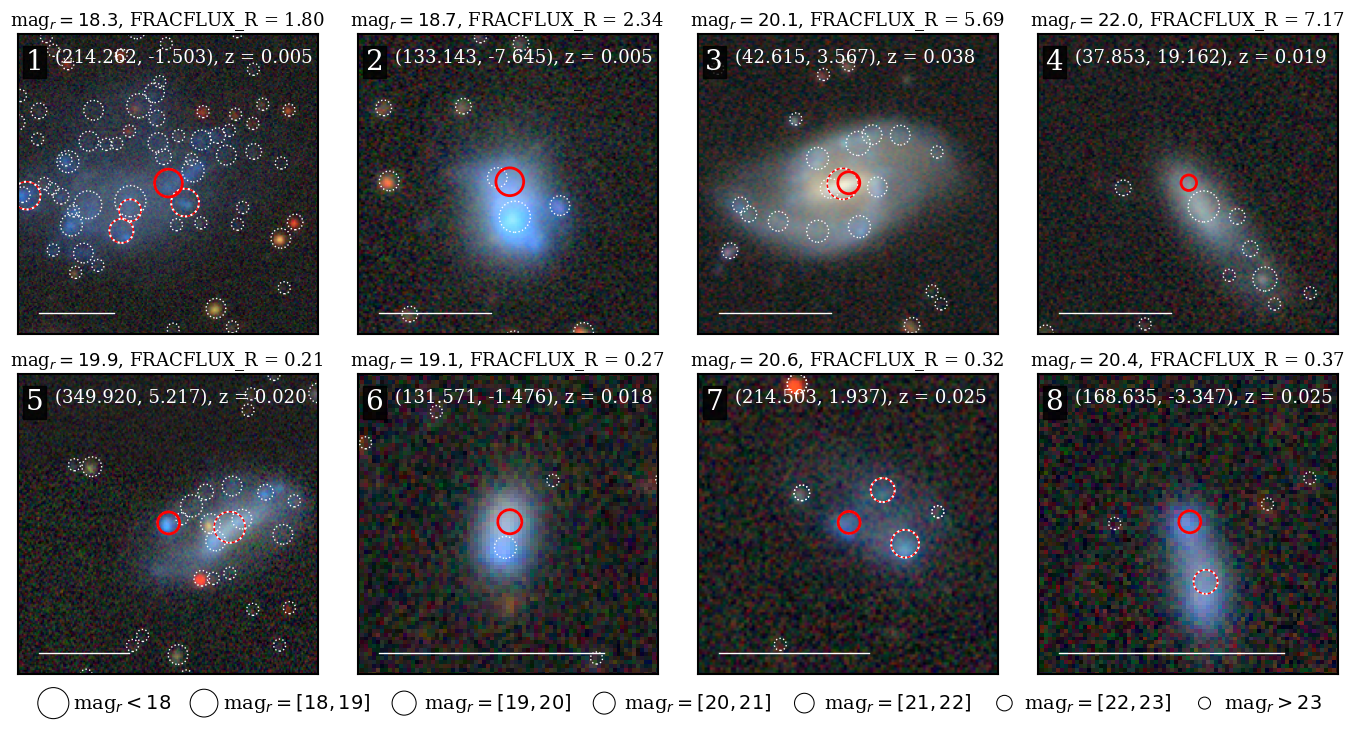

In [181]:
fig, axs = make_subplots(ncol = 4, nrow = 2, col_spacing = 0.4, row_spacing = 0.4, return_fig=True)

get_image_summary(axs[4], data_0, near_data_0, cutout_size = 60, img_folder = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/",fsize = 11,label = 1)
get_image_summary(axs[5], data_1, near_data_1, cutout_size = 40, img_folder = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/",fsize = 11,label = 2)
get_image_summary(axs[6], data_2, near_data_2, cutout_size = 40, img_folder = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/",fsize = 11,label = 3)
get_image_summary(axs[7], data_3, near_data_3, cutout_size = 40, img_folder = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/",fsize = 11,label = 4)


get_image_summary(axs[3], lowz_0, near_lowz_0, cutout_size = 20, img_folder = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/",fsize = 11,label = 8)
get_image_summary(axs[2], lowz_2, near_lowz_2, cutout_size = 30, img_folder = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/",fsize = 11,label = 7)
get_image_summary(axs[1], lowz_1, near_lowz_1, cutout_size = 20, img_folder = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/",fsize = 11,label = 6)
get_image_summary(axs[0], lowz_3, near_lowz_3, cutout_size = 50, img_folder = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/",fsize = 11,label = 5)



# Labels for the legend (use upper bound of each bin for clarity)
legend_labels = [r"mag$_r<18$", r"mag$_r = [18,19]$", r"mag$_r = [19,20]$", r"mag$_r = [20,21]$", r"mag$_r = [21,22]$", r"mag$_r = [22,23]$", r"mag$_r > 23$"]

# Create dummy scatter points for the legend
legend_scatters = [
    axs[0].scatter([], [], s=s, facecolor='none', edgecolor='k', lw=0.75)
    for s in marker_sizes  # skip last bin if desired
]

# Add a single legend below all subplots
fig.legend(handles=legend_scatters, labels=legend_labels,
           loc='lower center', ncol=len(legend_labels), frameon=False,
           bbox_to_anchor=(0.5, -0.015),fontsize = 14,handletextpad=0,columnspacing=0.7)


plt.savefig("plots/shreds_examples.pdf",bbox_inches="tight")

plt.show()


In [142]:
lowz_shred_egs[1]

2706212579704832

In [141]:
_,near_lowz_1 = search_around_radec(lowz_shred_egs[1], shred_all, total_cat,c_ra="RA",c_dec="DEC",search_rad_arc = 1,use_spectype=False)


Found 1 nearby sources


In [82]:
lowz_shred_egs[1]

2706212579704832

In [98]:
shred_all[shred_all["TARGETID"] == 39627836645965913]["RA","DEC","Z"]

RA,DEC,Z
deg,deg,
float64,float64,float64
214.50160460313367,1.9383331485152548,0.024952163159741622


In [100]:
shred_all[shred_all["TARGETID"] == 2706236185247745]["RA","DEC","Z"]

RA,DEC,Z
deg,deg,
float64,float64,float64
214.50253345946322,1.9374389475791407,0.025005114782113754


In [101]:
shred_all[shred_all["TARGETID"] == 39627836645965897]["RA","DEC","Z"]

RA,DEC,Z
deg,deg,
float64,float64,float64
214.50098547926598,1.9368504689277048,0.025087176061344297


In [102]:
def search_around_radec(tgid, dwarf_cat, catalog,c_ra="RA",c_dec="DEC",search_rad_arc = 60,use_spectype=True):
 
    ra_col = "RA"
    dec_col ="DEC" 
    center_cat = dwarf_cat[dwarf_cat["TARGETID"] == tgid]
    
    ra,dec,zred = center_cat[ra_col][0], center_cat[dec_col][0], center_cat["Z"][0]

    print(ra,dec)
    
    near_cat = find_objects_nearby(catalog, ra,dec,deg_rad = search_rad_arc/3600, ra=c_ra,dec=c_dec)

    print(len(near_cat))

    #only include galaxies that are at the same redshift!!
    near_cat = near_cat[np.abs(near_cat["Z"] - center_cat["Z"]) < 0.002]

    if use_spectype:
        print("Filtering by SPECTYPE")
        near_cat = near_cat[near_cat["SPECTYPE"] == "GALAXY"]

    print(f"Found {len(near_cat)} nearby sources")
    
    return center_cat, near_cat

In [10]:
# zpix_iron = fits.open("/global/cfs/cdirs/desi/spectro/redux/iron/zcatalog/v1/zall-pix-iron.fits")[1].data
# # # manually build a structured array with the desired fields
# cols = ["TARGET_RA","TARGET_DEC","SPECTYPE","Z","ZWARN","DELTACHI2","TARGETID","SURVEY","PROGRAM","HEALPIX"]
# zpix_iron_small = np.core.records.fromarrays([zpix_iron[c] for c in cols], names=cols)
# zpix_iron_small = zpix_iron_small[(zpix_iron_small["Z"] < 0.039) & (zpix_iron_small["Z"] > 0.005)]
# hdu = fits.BinTableHDU(zpix_iron_small)
# # suppose zpix_iron_small is already a Table
# hdu.writeto("/pscratch/sd/v/virajvm/trash/zpix_iron_small_v2.fits", overwrite=True)

Filtering by SPECTYPE
Found 5 nearby sources


In [16]:
cat

TARGET_RA,TARGET_DEC,SPECTYPE,Z,ZWARN,DELTACHI2,TARGETID,SURVEY,PROGRAM,HEALPIX
float64,float64,bytes6,float64,int64,float64,int64,bytes7,bytes6,int32
214.26114134541552,-1.5044084469165917,GALAXY,0.00508421957175602,0,2128.7520497860387,39627752084603161,main,bright,25917
214.26206310270314,-1.503325260416453,GALAXY,0.005100370197435037,0,340.5736112120794,39627752084603180,main,bright,25917
214.2646771246212,-1.5059799435903922,GALAXY,0.005182542382842411,0,10.502171723645006,39627752084603252,main,bright,25917
214.26994879450172,-1.5040204084965207,GALAXY,0.005252139872654256,0,1391.8351195929572,39627752084603392,main,bright,25917
214.2641978480642,-1.5048401793636192,GALAXY,0.005172394958504232,0,64.32400042118388,39627752084603243,main,dark,25917


In [116]:
inds = np.array([0,1,2,-3])

In [124]:
bgsb_shreds[inds].write("/pscratch/sd/v/virajvm/trash/john_examples.fits",overwrite=True)

In [128]:
bgsb_shreds["APER_PARAMS"][:,0]*0.262*3

5.931859628426664
3.9323193289606984
13.157952557148285
7.46325739200289
6.268411440952509
2.7525246601618303
11.017265431234959
2.9680526024993292
8.054246195541607
3.461430427882143
9.537469963602947
